In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision import transforms
import torch
from PIL import ImageOps
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split


class CenterCropWithPadding:
    def __init__(self, crop_size=250, padding_mode='constant', fill=0):
        self.crop_size = crop_size
        self.padding_mode = padding_mode
        self.fill = fill  # 0 for black, 255 for white

    def __call__(self, image, center):
        x_center, y_center = center

        # Image size
        width, height = image.size

        # Calculate box
        half_crop = self.crop_size // 2
        left = int(x_center) - half_crop
        top = int(y_center) - half_crop
        right = int(x_center) + half_crop
        bottom = int(y_center) + half_crop

        # Calculate how much padding is needed
        pad_left = max(0, -left)
        pad_top = max(0, -top)
        pad_right = max(0, right - width)
        pad_bottom = max(0, bottom - height)

        # Pad if necessary
        if pad_left > 0 or pad_top > 0 or pad_right > 0 or pad_bottom > 0:
            padding = (pad_left, pad_top, pad_right, pad_bottom)
            image = ImageOps.expand(image, border=padding, fill=self.fill)

            # After padding, update box coordinates
            left += pad_left
            top += pad_top
            right += pad_left
            bottom += pad_top

        # Crop
        image = image.crop((left, top, left + self.crop_size, top + self.crop_size))

        # Convert to Tensor
        image = transforms.ToTensor()(image)

        return image

In [ ]:


class CenterPointDataset(Dataset):
    def __init__(self, csv_file, root_dir, crop_size=500, padding_fill=0, train=True):
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.crop_size = crop_size
        self.train = train
        self.cropper = CenterCropWithPadding(crop_size=crop_size, fill=padding_fill)
        self.labels_frame['filename'] = self.labels_frame['filename'].apply(self.clean_path)

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_rel_path = self.labels_frame.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_rel_path)
        image = Image.open(img_path).convert('RGB')
        x_center = self.labels_frame.iloc[idx, 1]
        y_center = self.labels_frame.iloc[idx, 2]
        # print("x_center before: ", x_center)

        if self.train:
            random_x_offset = random.uniform(-self.crop_size // 2 + 20, self.crop_size // 2 - 20)
            random_y_offset = random.uniform(-self.crop_size // 2 + 20, self.crop_size // 2 - 20)
        else:
            random_x_offset = 0
            random_y_offset = 0

        # Apply the custom crop
        x_center = x_center + random_x_offset
        y_center = y_center + random_y_offset
        image = self.cropper(image, center=(x_center, y_center))
        # print("x_center after: ", x_center)
        label = torch.tensor([-random_x_offset + self.crop_size // 2, -random_y_offset + self.crop_size // 2], dtype=torch.float32)

        return image, label

    @staticmethod
    def clean_path(path):
        """
        Clean up the path to format: 2:22_2:28/frame_00018.jpg
        """
        # Extract the part after 'data\\frames\\...\\'
        match = re.search(r'data\\frames\\[^\\]+\\(.+)', path)
        if match:
            sub_path = match.group(1)
        else:
            sub_path = path  # fallback if regex fails

        frame_idx = sub_path.find('frame_')
        prefix = sub_path[:frame_idx]  # e.g., '2_22_2_28'
        filename = sub_path[frame_idx:]  # e.g., 'frame_00018.jpg'

        # Now, split prefix into two groups (start_time and end_time)
        times = prefix.strip('_').split('_')
        if len(times) >= 4:
            start_time = f"{times[0]}:{times[1]}"  # e.g., 2:22
            end_time = f"{times[2]}:{times[3]}"    # e.g., 2:28
            prefix_clean = f"{start_time}_{end_time}"
        else:
            # fallback if somehow format is wrong
            prefix_clean = prefix.replace('_', ':')

        return f"{prefix_clean}/{filename}"

In [ ]:
csv_path = '/content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women\'s.mp4/centered.csv'
full_df = pd.read_csv(csv_path)

# Split into train and validation (80% train, 20% val)
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

# Save them to temp CSVs
train_csv_path = '/content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women\'s.mp4/train_split.csv'
val_csv_path = '/content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women\'s.mp4/val_split.csv'
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

In [ ]:
from torch.utils.data import ConcatDataset

root_dir = '/content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women\'s.mp4/'  # <--- folder where you extracted your images

train_dataset = CenterPointDataset(csv_file=train_csv_path, root_dir=root_dir, crop_size=500, train=True)
val_dataset = CenterPointDataset(csv_file=val_csv_path, root_dir=root_dir, crop_size=500, train=True)

# Create DataLoader
train_dataset = ConcatDataset([train_dataset] * 5)
val_dataset = ConcatDataset([val_dataset] * 5)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# # Example: Iterate through DataLoader
# for images, labels in val_loader:
#     print(images.shape)  # (batch_size, 3, 128, 128)
#     print(labels)        # batch of (x_center, y_center)

#     img = images[0].permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
#     label = labels[0]
#     plt.imshow(img)
#     # show the label on the image as well:
#     plt.scatter(label[0], label[1], color='red', s=10)  # Red dot at center

#     plt.axis('off')
#     plt.title(f"Center (original): ({labels[0][0]:.1f}, {labels[0][1]:.1f})")
#     plt.show()




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm

class CoordResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # 1) Load a ResNet18 and replace first conv to accept 5 channels (RGB + X + Y)
        backbone = resnet18(pretrained=pretrained)
        w0 = backbone.conv1.weight.data.clone()  # (64,3,7,7)
        self.conv1 = nn.Conv2d(
            in_channels=5, out_channels=64,
            kernel_size=7, stride=2, padding=3, bias=False
        )
        # init: copy pretrained RGB weights, zero for the two coord channels
        with torch.no_grad():
            self.conv1.weight[:, :3] = w0
            self.conv1.weight[:, 3:] = 0

        # 2) Hook the rest of ResNet (but **remove** its fc)
        self.backbone = nn.Sequential(
            self.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
            backbone.avgpool,   # outputs (B,512,1,1)
        )
        # 3) A small regression head on top
        self.regressor = nn.Sequential(
            nn.Flatten(),         # → (B,512)
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 2),    # predict normalized (x, y) in [0,1]
        )

    def forward(self, x):
        # x: (B,3,H,W) in [0,1]
        B, C, H, W = x.shape

        # build coord channels, normalized to [-1,1]
        xs = torch.linspace(-1, 1, steps=W, device=x.device)
        ys = torch.linspace(-1, 1, steps=H, device=x.device)
        grid_x = xs.view(1, 1, 1, W).expand(B, 1, H, W)
        grid_y = ys.view(1, 1, H, 1).expand(B, 1, H, W)

        x = torch.cat([x, grid_x, grid_y], dim=1)  # → (B,5,H,W)
        f = self.backbone(x)                       # → (B,512,1,1)
        out = self.regressor(f)                    # → (B,2) in roughly [-1,1]
        # map from [-1,1] to [0,1]
        out = (out + 1) * 0.5
        return out


# ————— Instantiate, loss, optimizer —————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoordResNet18(pretrained=True).to(device)
criterion = nn.SmoothL1Loss()   # Huber loss is often more robust than plain MSE
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ————— Training & validation loops (normalized coords) —————
def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    for imgs, centers in tqdm(loader, desc="Train"):
        # imgs: [B,3,H,W] @ float32 in [0,1]
        # centers: [B,2] in pixel coords → normalize to [0,1]
        imgs = imgs.to(device)
        centers = centers.to(device)
        H, W = imgs.shape[-2:]
        centers_norm = centers / torch.tensor([W, H], device=device)

        preds = model(imgs)                    # [B,2] in [0,1]
        loss = criterion(preds, centers_norm)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(loader):
    model.eval()
    total_loss = 0.0
    total_err  = 0.0
    for imgs, centers in tqdm(loader, desc="Val"):
        imgs = imgs.to(device)
        centers = centers.to(device)
        H, W = imgs.shape[-2:]
        centers_norm = centers / torch.tensor([W, H], device=device)

        preds = model(imgs)
        loss = criterion(preds, centers_norm)
        total_loss += loss.item() * imgs.size(0)

        # convert preds back to pixel coords
        preds_px = preds * torch.tensor([W, H], device=device)
        err = torch.norm(preds_px - centers, dim=1).sum().item()
        total_err += err

    avg_loss = total_loss / len(loader.dataset)
    avg_err  = total_err  / len(loader.dataset)
    return avg_loss, avg_err

# ————— Run training —————
num_epochs = 20
best_val = float("inf")
for epoch in range(1, num_epochs+1):
    tr_loss = train_one_epoch(train_loader)
    val_loss, val_err = validate(val_loader)
    print(f"Epoch {epoch:02d}  TrainLoss={tr_loss:.4f}  ValLoss={val_loss:.4f}  ValErr={val_err:.1f}px")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_coordresnet18.pth")
        print(" ↳ saved best model")

print("Done. Best validation loss:", best_val)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Val: 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]


Epoch 01  TrainLoss=0.0242  ValLoss=0.0164  ValErr=114.1px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:07<00:00,  4.54it/s]


Epoch 02  TrainLoss=0.0151  ValLoss=0.0119  ValErr=92.4px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:06<00:00,  4.76it/s]


Epoch 03  TrainLoss=0.0123  ValLoss=0.0080  ValErr=75.1px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]


Epoch 04  TrainLoss=0.0097  ValLoss=0.0093  ValErr=82.9px


Val: 100%|██████████| 33/33 [00:06<00:00,  4.78it/s]


Epoch 05  TrainLoss=0.0076  ValLoss=0.0047  ValErr=57.5px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:06<00:00,  4.79it/s]


Epoch 06  TrainLoss=0.0070  ValLoss=0.0056  ValErr=59.2px


Val: 100%|██████████| 33/33 [00:05<00:00,  5.65it/s]


Epoch 07  TrainLoss=0.0061  ValLoss=0.0064  ValErr=64.6px


Val: 100%|██████████| 33/33 [00:07<00:00,  4.46it/s]


Epoch 08  TrainLoss=0.0054  ValLoss=0.0058  ValErr=61.5px


Val: 100%|██████████| 33/33 [00:06<00:00,  5.08it/s]


Epoch 09  TrainLoss=0.0054  ValLoss=0.0043  ValErr=52.4px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


Epoch 10  TrainLoss=0.0046  ValLoss=0.0046  ValErr=53.1px


Val: 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]


Epoch 11  TrainLoss=0.0046  ValLoss=0.0043  ValErr=53.2px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:05<00:00,  5.67it/s]


Epoch 12  TrainLoss=0.0045  ValLoss=0.0049  ValErr=57.3px


Val: 100%|██████████| 33/33 [00:06<00:00,  4.83it/s]


Epoch 13  TrainLoss=0.0038  ValLoss=0.0035  ValErr=46.4px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:06<00:00,  5.30it/s]


Epoch 14  TrainLoss=0.0036  ValLoss=0.0026  ValErr=41.6px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]


Epoch 15  TrainLoss=0.0031  ValLoss=0.0037  ValErr=44.8px


Val: 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]


Epoch 16  TrainLoss=0.0030  ValLoss=0.0048  ValErr=53.3px


Val: 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]


Epoch 17  TrainLoss=0.0031  ValLoss=0.0038  ValErr=46.6px


Val: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Epoch 18  TrainLoss=0.0025  ValLoss=0.0040  ValErr=45.8px


Val: 100%|██████████| 33/33 [00:06<00:00,  5.18it/s]


Epoch 19  TrainLoss=0.0024  ValLoss=0.0026  ValErr=37.8px
 ↳ saved best model


Val: 100%|██████████| 33/33 [00:06<00:00,  5.09it/s]

Epoch 20  TrainLoss=0.0023  ValLoss=0.0033  ValErr=45.7px
Done. Best validation loss: 0.002627807318304594


In [ ]:
model = CoordResNet18().to(device)
model.load_state_dict(torch.load("best_coordresnet18.pth"))
model.eval()

CoordResNet18(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (backbone): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
import torch
import numpy as np

@torch.no_grad()
def evaluate_predictions(
    loader,
    model,
    device,
    normalized_preds=True
):
    model.eval()

    all_dists = []
    all_x_diffs = []
    all_y_diffs = []

    for imgs, centers in loader:
        imgs = imgs.to(device)
        centers = centers.to(device)

        B, C, H, W = imgs.shape
        preds = model(imgs)

        if normalized_preds:
            scale = torch.tensor([W, H], device=device).view(1, 2)
            preds = preds * scale

        preds_np = preds.cpu().numpy()
        gts_np = centers.cpu().numpy()

        diffs = preds_np - gts_np
        dists = np.linalg.norm(diffs, axis=1)

        all_dists.extend(dists.tolist())
        all_x_diffs.extend(np.abs(diffs[:, 0]).tolist())
        all_y_diffs.extend(np.abs(diffs[:, 1]).tolist())

    stats = {
        "mean_distance": np.mean(all_dists),
        "max_distance": np.max(all_dists),
        "std_distance": np.std(all_dists),
        "mean_x_diff": np.mean(all_x_diffs),
        "mean_y_diff": np.mean(all_y_diffs),
        "max_x_diff": np.max(all_x_diffs),
        "max_y_diff": np.max(all_y_diffs),
        "std_x_diff": np.std(all_x_diffs),
        "std_y_diff": np.std(all_y_diffs),
        "num_samples": len(all_dists)
    }

    print("\nEvaluation Statistics:")
    for k, v in stats.items():
        print(f"{k:>20}: {v:.4f}")

    return stats
evaluate_predictions(
    val_loader,
    model,
    device,
    normalized_preds=True
)


Evaluation Statistics:
       mean_distance: 20.8411
        max_distance: 163.8701
        std_distance: 22.5429
         mean_x_diff: 15.5104
         mean_y_diff: 10.9352
          max_x_diff: 154.5611
          max_y_diff: 89.2915
          std_x_diff: 20.5986
          std_y_diff: 12.5732
         num_samples: 260.0000


{'mean_distance': np.float64(20.84112308896505),
 'max_distance': np.float64(163.8701171875),
 'std_distance': np.float64(22.542941940311188),
 'mean_x_diff': np.float64(15.51037222788884),
 'mean_y_diff': np.float64(10.935220645024227),
 'max_x_diff': np.float64(154.5611114501953),
 'max_y_diff': np.float64(89.29153442382812),
 'std_x_diff': np.float64(20.59856443184863),
 'std_y_diff': np.float64(12.573189967705126),
 'num_samples': 260}


Evaluation Statistics:
       mean_distance: 36.4975
        max_distance: 262.4333
        std_distance: 34.7280
         mean_x_diff: 28.5307
         mean_y_diff: 17.4383
          max_x_diff: 250.9457
          max_y_diff: 115.4010
          std_x_diff: 34.0710
          std_y_diff: 16.0987
         num_samples: 260.0000


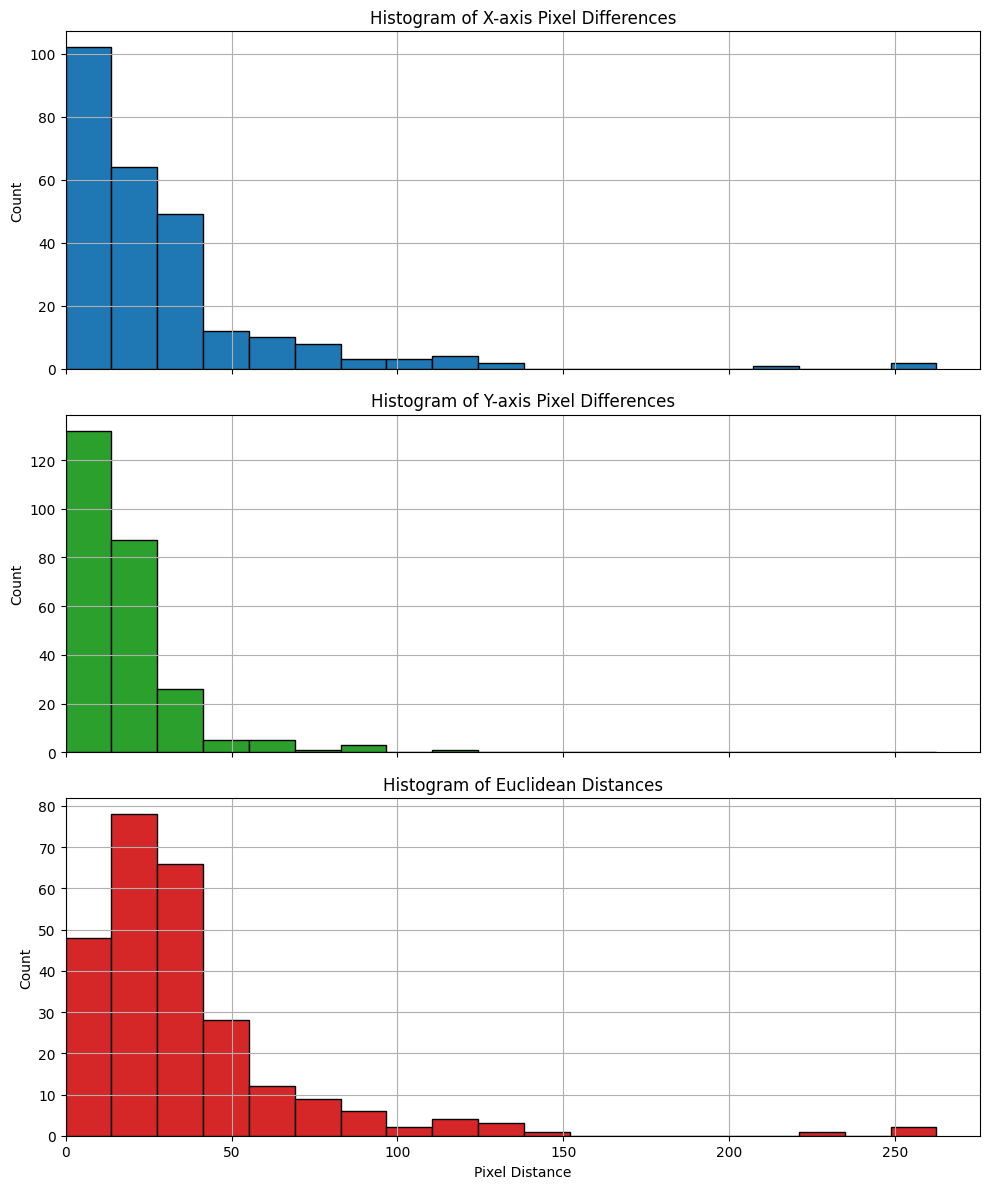

{'mean_distance': np.float64(36.49747023674158),
 'max_distance': np.float64(262.4332580566406),
 'std_distance': np.float64(34.727993823765246),
 'mean_x_diff': np.float64(28.530738295041598),
 'mean_y_diff': np.float64(17.438308224311243),
 'max_x_diff': np.float64(250.9457244873047),
 'max_y_diff': np.float64(115.40100860595703),
 'std_x_diff': np.float64(34.070996213585424),
 'std_y_diff': np.float64(16.098709547980388),
 'num_samples': 260}

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate_predictions_with_plots(
    loader,
    model,
    device,
    normalized_preds=True
):
    model.eval()

    all_dists = []
    all_x_diffs = []
    all_y_diffs = []

    for imgs, centers in loader:
        imgs = imgs.to(device)
        centers = centers.to(device)

        B, C, H, W = imgs.shape
        preds = model(imgs)

        if normalized_preds:
            scale = torch.tensor([W, H], device=device).view(1, 2)
            preds = preds * scale

        preds_np = preds.cpu().numpy()
        gts_np = centers.cpu().numpy()

        diffs = preds_np - gts_np
        dists = np.linalg.norm(diffs, axis=1)

        all_dists.extend(dists.tolist())
        all_x_diffs.extend(np.abs(diffs[:, 0]).tolist())
        all_y_diffs.extend(np.abs(diffs[:, 1]).tolist())

    # Compute statistics
    stats = {
        "mean_distance": np.mean(all_dists),
        "max_distance": np.max(all_dists),
        "std_distance": np.std(all_dists),
        "mean_x_diff": np.mean(all_x_diffs),
        "mean_y_diff": np.mean(all_y_diffs),
        "max_x_diff": np.max(all_x_diffs),
        "max_y_diff": np.max(all_y_diffs),
        "std_x_diff": np.std(all_x_diffs),
        "std_y_diff": np.std(all_y_diffs),
        "num_samples": len(all_dists)
    }

    print("\nEvaluation Statistics:")
    for k, v in stats.items():
        print(f"{k:>20}: {v:.4f}")

    # Create histogram bins
    max_dist = max(np.max(all_x_diffs), np.max(all_y_diffs), np.max(all_dists))
    bins = np.linspace(0, max_dist, 20)

    # Plot histograms
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    axs[0].hist(all_x_diffs, bins=bins, color='tab:blue', edgecolor='black')
    axs[0].set_xlim(left=0)
    axs[0].set_title('Histogram of X-axis Pixel Differences')
    axs[0].set_ylabel('Count')
    axs[0].grid(True)

    axs[1].hist(all_y_diffs, bins=bins, color='tab:green', edgecolor='black')
    axs[1].set_xlim(left=0)
    axs[1].set_title('Histogram of Y-axis Pixel Differences')
    axs[1].set_ylabel('Count')
    axs[1].grid(True)

    axs[2].hist(all_dists, bins=bins, color='tab:red', edgecolor='black')
    axs[2].set_xlim(left=0)
    axs[2].set_title('Histogram of Euclidean Distances')
    axs[2].set_xlabel('Pixel Distance')
    axs[2].set_ylabel('Count')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

    return stats
evaluate_predictions_with_plots(
    val_loader,
    model,
    device,
    normalized_preds=True
)


Evaluation Statistics:
       mean_distance: 24.5138
        max_distance: 130.4431
        std_distance: 15.0406
         mean_x_diff: 17.4869
         mean_y_diff: 13.4315
          max_x_diff: 115.5218
          max_y_diff: 115.0049
          std_x_diff: 13.9532
          std_y_diff: 12.0936
         num_samples: 1040.0000


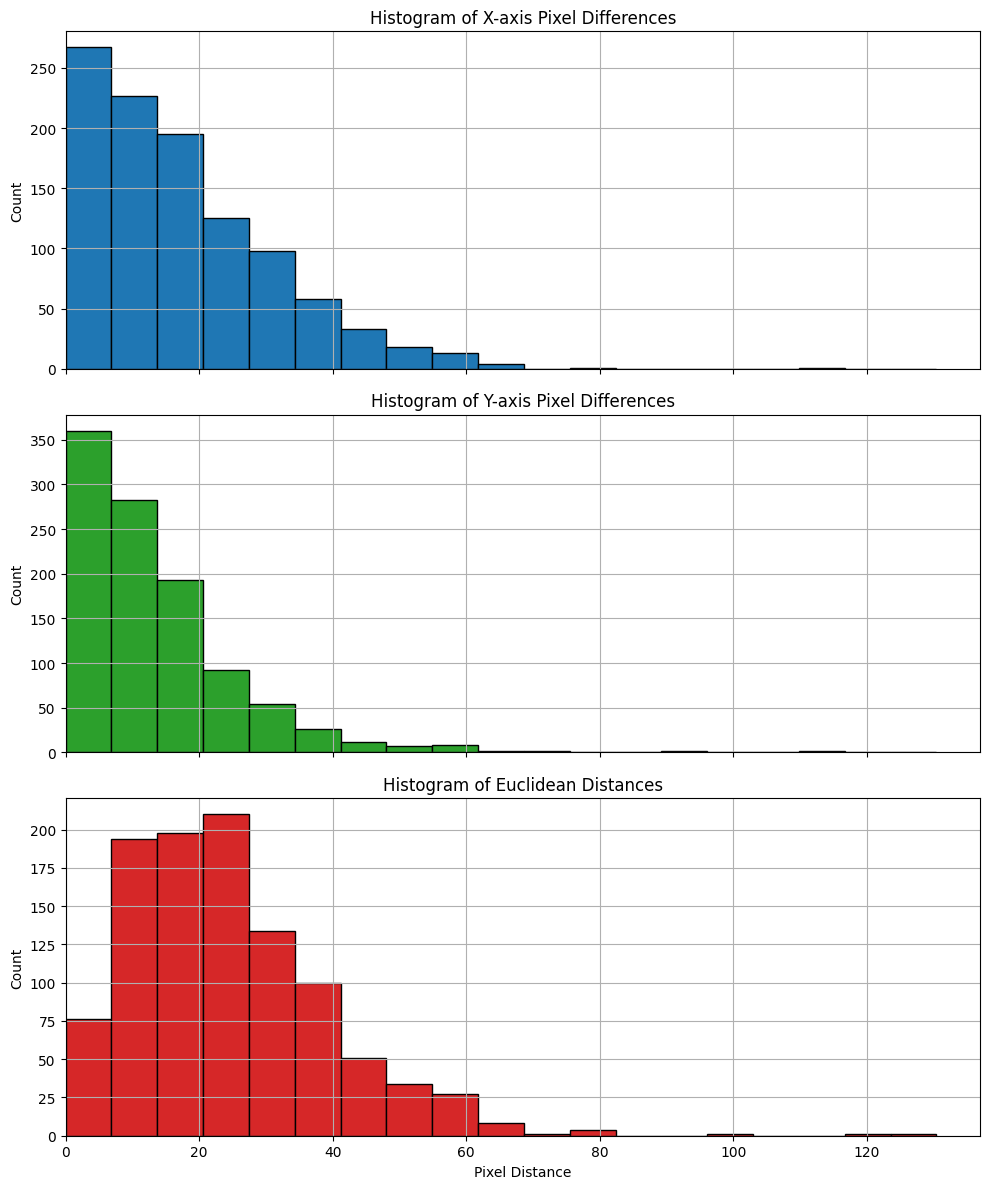

{'mean_distance': np.float64(24.513795529133997),
 'max_distance': np.float64(130.44309997558594),
 'std_distance': np.float64(15.040566916036026),
 'mean_x_diff': np.float64(17.486934942465563),
 'mean_y_diff': np.float64(13.43151794396914),
 'max_x_diff': np.float64(115.52183532714844),
 'max_y_diff': np.float64(115.00489807128906),
 'std_x_diff': np.float64(13.953171915252451),
 'std_y_diff': np.float64(12.093603763737235),
 'num_samples': 1040}

In [ ]:
evaluate_predictions_with_plots(
    train_loader,
    model,
    device,
    normalized_preds=True
)

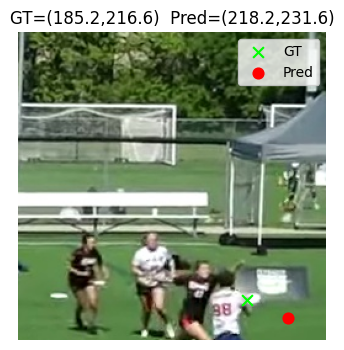

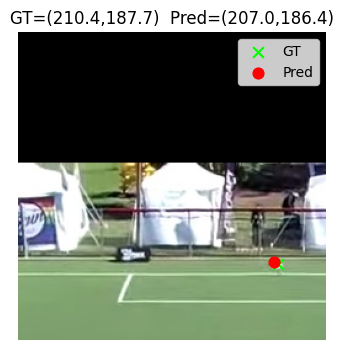

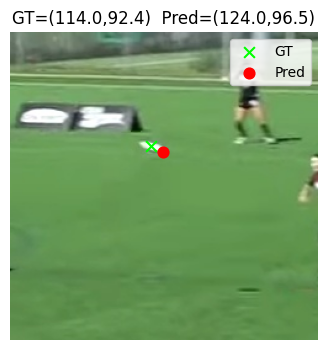

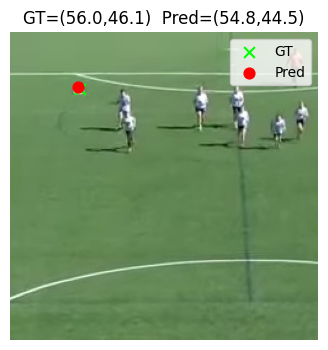

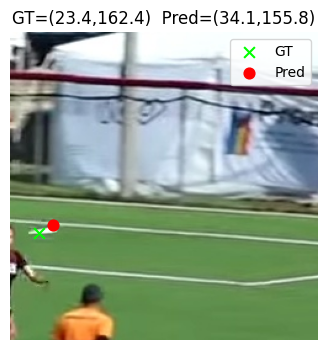

In [ ]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_predictions(
    loader,
    model,
    device,
    num_images=5,
    normalized_preds=True  # set to False if your model already outputs pixel coords
):
    model.eval()
    shown = 0

    for imgs, centers in loader:
        imgs    = imgs.to(device)    # [B,3,H,W]
        centers = centers.to(device) # [B,2]

        B, C, H, W = imgs.shape
        preds = model(imgs)          # [B,2]

        # if your network predicts normalized coords in [0,1], scale back:
        if normalized_preds:
            scale = torch.tensor([W, H], device=device).view(1,2)
            preds = preds * scale

        preds = preds.cpu().numpy()
        gts   = centers.cpu().numpy()
        imgs_np = imgs.cpu().permute(0,2,3,1).numpy()  # [B,H,W,3]

        for img_arr, gt_xy, pred_xy in zip(imgs_np, gts, preds):
            fig, ax = plt.subplots(figsize=(4,4))
            ax.imshow(img_arr)
            ax.axis('off')

            gt_x, gt_y     = gt_xy
            pred_x, pred_y = pred_xy

            # plot ground-truth
            ax.scatter(gt_x, gt_y, s=60, c='lime', marker='x', label='GT')
            # plot prediction
            ax.scatter(pred_x, pred_y, s=60, c='red', marker='o', label='Pred')

            ax.legend(loc='upper right')
            ax.set_title(f"GT=({gt_x:.1f},{gt_y:.1f})  Pred=({pred_x:.1f},{pred_y:.1f})")

            plt.show()

            shown += 1
            if shown >= num_images:
                return

# ——— Usage ———
# If you’re using the CoordResNet18 from the last snippet (which predicts normalized [0,1]):
visualize_predictions(
    train_loader,
    model,
    device,
    num_images=5,
    normalized_preds=True
)

# If you revert to the small custom CNN that outputs raw pixel coords, set:
# normalized_preds=False


In [ ]:
import torch
import torch.nn as nn

class CoordCNN(nn.Module):
    def __init__(self):
        super(CoordCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (B, 32, 250, 250)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 125, 125)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (B, 64, 125, 125)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 64, 62, 62)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (B, 128, 62, 62)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 128, 31, 31)
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),                # (B, 123008)
            nn.Linear(128 * 31 * 31, 512),
            nn.ReLU(),
            nn.Linear(512, 2)             # Output (x, y)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CoordCNN().to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)  # (batch_size, 2)

        outputs = model(images)       # (batch_size, 2)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

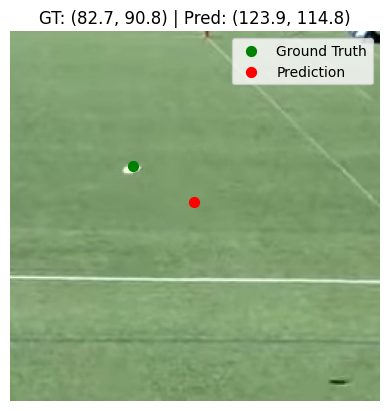

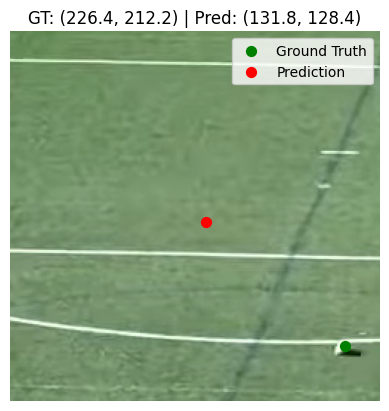

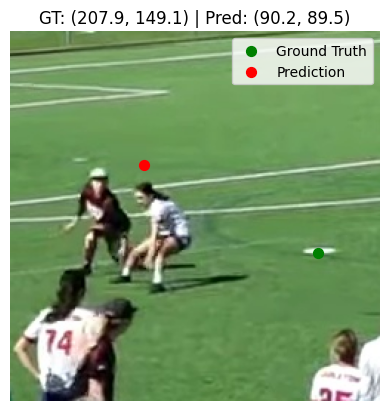

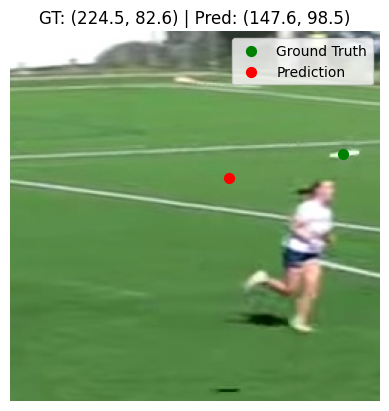

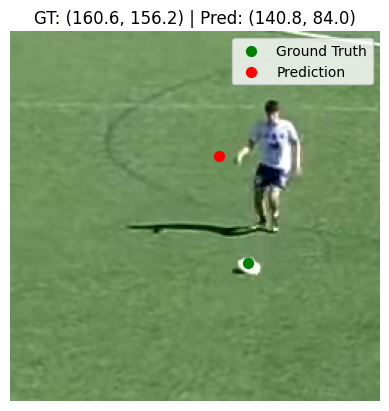

In [ ]:
visualize_predictions(train_loader, num_images=5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!python /content/drive/MyDrive/cs231n/projects/baseline_crop_and_sam_tracking.py --method "baseline"

python3: can't open file '/content/drive/MyDrive/cs231n/projects/baseline_crop_and_sam_tracking.py': [Errno 2] No such file or directory


In [ ]:
!python /content/drive/MyDrive/cs231n/projects/baseline_crop_and_sam_tracking.py --method "autogressive_sam_baseline" --crop_size 250

2025-06-05 03:27:58.817336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749094078.837898   69200 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749094078.844163   69200 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 03:27:58.865378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
first frame: /content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women's.mp

In [ ]:
!python /content/drive/MyDrive/cs231n/projects/baseline_crop_and_sam_tracking.py --method "autogressive_sam_resnet" --crop_size 250 --grounded True

2025-06-05 04:20:31.030970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749097231.052084   82589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749097231.058137   82589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 04:20:31.078429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
first frame: /content/drive/MyDrive/cs231n/projects/frames_for_CNN/Double_Game_Point_Carleton_vs._Stanford_Women's.mp

In [ ]:
!pwd

/content
